In [4]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Input, UpSampling2D, concatenate, Multiply, Add, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing import image

from glob import glob
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from rich.console import Console
from rich.table import Table

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# import zipfile
# import os

# zip_path = "/content/drive/MyDrive/kaggle_3m.zip"
# extract_path = "/content/drive/MyDrive/kaggle_3m_extracted"

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)
#     print("Files extracted successfully!")


Files extracted successfully!


In [8]:
dataset_path = '/content/drive/MyDrive/kaggle_3m_extracted/kaggle_3m'
patients = os.listdir(dataset_path)
print(f"Total patients in the dataset: {len(patients)}")

Total patients in the dataset: 112


In [9]:
example_patient = random.choice(patients)
example_patient_path = os.path.join(dataset_path, example_patient)
print(f"Files in {example_patient}:")
print(os.listdir(example_patient_path))

Files in TCGA_HT_7877_19980917:
['TCGA_HT_7877_19980917_1.tif', 'TCGA_HT_7877_19980917_10.tif', 'TCGA_HT_7877_19980917_10_mask.tif', 'TCGA_HT_7877_19980917_11.tif', 'TCGA_HT_7877_19980917_11_mask.tif', 'TCGA_HT_7877_19980917_12.tif', 'TCGA_HT_7877_19980917_12_mask.tif', 'TCGA_HT_7877_19980917_13.tif', 'TCGA_HT_7877_19980917_13_mask.tif', 'TCGA_HT_7877_19980917_14.tif', 'TCGA_HT_7877_19980917_14_mask.tif', 'TCGA_HT_7877_19980917_15.tif', 'TCGA_HT_7877_19980917_15_mask.tif', 'TCGA_HT_7877_19980917_16.tif', 'TCGA_HT_7877_19980917_16_mask.tif', 'TCGA_HT_7877_19980917_17.tif', 'TCGA_HT_7877_19980917_17_mask.tif', 'TCGA_HT_7877_19980917_18.tif', 'TCGA_HT_7877_19980917_18_mask.tif', 'TCGA_HT_7877_19980917_19.tif', 'TCGA_HT_7877_19980917_19_mask.tif', 'TCGA_HT_7877_19980917_1_mask.tif', 'TCGA_HT_7877_19980917_2.tif', 'TCGA_HT_7877_19980917_20.tif', 'TCGA_HT_7877_19980917_20_mask.tif', 'TCGA_HT_7877_19980917_21.tif', 'TCGA_HT_7877_19980917_21_mask.tif', 'TCGA_HT_7877_19980917_22.tif', 'TCGA_HT_

In [10]:
def get_image_mask_paths(patient_path):
    image_paths = glob(os.path.join(patient_path, '*.tif'))
    mask_paths = [path for path in image_paths if 'mask' in os.path.basename(path)]
    image_paths = [path for path in image_paths if 'mask' not in os.path.basename(path)]
    return image_paths, mask_paths

image_paths, mask_paths = get_image_mask_paths(example_patient_path)
print(f"Number of images: {len(image_paths)}, Number of masks: {len(mask_paths)}")

Number of images: 30, Number of masks: 30


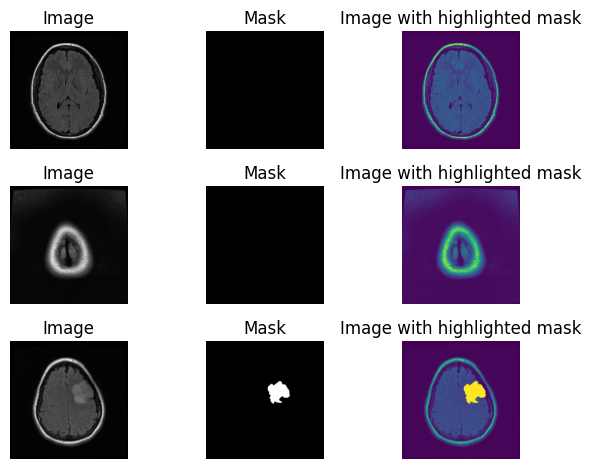

In [11]:
num_images_to_display = 3
selected_image_paths = random.sample(image_paths, num_images_to_display)
selected_mask_paths = [path.replace('.tif', '_mask.tif') for path in selected_image_paths]

for i, (img_path, mask_path) in enumerate(zip(selected_image_paths, selected_mask_paths)):

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)

    plt.subplot(num_images_to_display, 3, 3 * i + 1)
    plt.imshow(img, cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(num_images_to_display, 3, 3 * i + 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    img_copy = img.copy()
    contours, hier = cv2.findContours(mask[:, :, 0], cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask_over_image = cv2.drawContours(img_copy, contours, -1, [255, 0, 0], thickness=-1)
    plt.subplot(num_images_to_display, 3, 3 * i + 3)
    plt.imshow(mask_over_image)
    plt.title('Image with highlighted mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
height = 128
width = 128
channels = 3

def load_and_preprocess_data(data_path, height, width):
    X = []
    Y = []
    folder_ids = os.listdir(data_path)
    for folder_id in tqdm(folder_ids):
        folder_path = os.path.join(data_path, folder_id)
        image_paths, _ = get_image_mask_paths(folder_path)
        for img_path in image_paths:

            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (width, height))
            img = img / 255.0
            X.append(img)

            mask_path = img_path.replace('.tif', '_mask.tif')
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (width, height))
            mask = mask / 255.0
            mask = np.where(mask > 0.5, 1.0, 0.0)
            Y.append(mask)

    X = np.array(X)
    Y = np.array(Y)
    Y = np.expand_dims(Y, axis=-1)
    print(f"Shape of X: {X.shape}")
    print(f"Shape of Y: {Y.shape}")
    return X, Y


In [13]:
X, Y = load_and_preprocess_data(dataset_path, height, width)

  0%|          | 0/112 [00:00<?, ?it/s]

Shape of X: (3929, 128, 128, 3)
Shape of Y: (3929, 128, 128, 1)


In [23]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5)

print(f"Training set size: {X_train.shape[0]} images")
print(f"Validation set size: {X_val.shape[0]} images")
print(f"Test set size: {X_test.shape[0]} images")

Training set size: 3143 images
Validation set size: 393 images
Test set size: 393 images


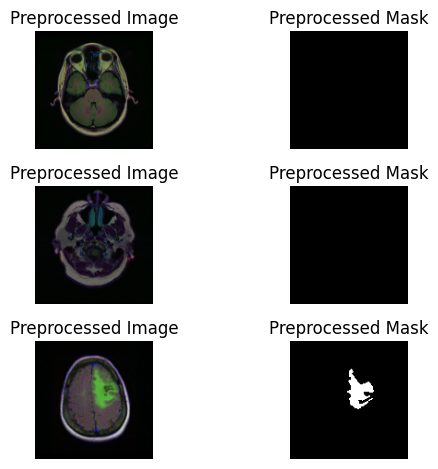

In [24]:
num_images_to_display = 3
indices = random.sample(range(X_train.shape[0]), num_images_to_display)

for i, idx in enumerate(indices):
    img = X_train[idx]
    mask = Y_train[idx].squeeze()

    plt.subplot(num_images_to_display, 2, 2 * i + 1)
    plt.imshow(img, cmap='gray')
    plt.title('Preprocessed Image')
    plt.axis('off')

    plt.subplot(num_images_to_display, 2, 2 * i + 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Preprocessed Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

# U-Net Architecture

In [25]:
def downsample(inputs, filters, kernel_size=(3, 3), pool_size=(2, 2)):
    c = Conv2D(filters, kernel_size, activation='relu', padding='same')(inputs)
    c = Conv2D(filters, kernel_size, activation='relu', padding='same')(c)

    p = MaxPooling2D(pool_size)(c)

    return c, p

In [26]:
def upsample(inputs, skip_connection, filters, kernel_size=(3, 3)):
    u = UpSampling2D((2, 2))(inputs)

    u = concatenate([u, skip_connection], axis=3)

    c = Conv2D(filters, kernel_size, activation='relu', padding='same')(u)
    c = Conv2D(filters, kernel_size, activation='relu', padding='same')(c)

    return c

In [27]:
def unet_model(input_size=(height, width, channels)):
    inputs = Input(input_size)

    c1, p1 = downsample(inputs, 64)
    c2, p2 = downsample(p1, 128)
    c3, p3 = downsample(p2, 256)
    c4, p4 = downsample(p3, 512)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    c6 = upsample(c5, c4, 512)
    c7 = upsample(c6, c3, 256)
    c8 = upsample(c7, c2, 128)
    c9 = upsample(c8, c1, 64)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [28]:
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 64)     │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 128)    │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 16, 16, 256)    │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 8, 8, 512)      │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_4           │ (None, 16, 16, 1024)   │              0 │ conv2d_28[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4        

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6, verbose=1),
    ModelCheckpoint('model-brain-mri-segmentation.weights.h5', save_best_only=True, save_weights_only=True, verbose=1)
]

In [30]:
BATCH_SIZE = 32
EPOCHS = 20

In [31]:
results = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_32']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9443 - loss: 0.2333
Epoch 1: val_loss improved from inf to 0.03360, saving model to model-brain-mri-segmentation.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 109s 973ms/step - accuracy: 0.9447 - loss: 0.2320 - val_accuracy: 0.9874 - val_loss: 0.0336 - learning_rate: 0.0010
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9904 - loss: 0.0286
Epoch 2: val_loss improved from 0.03360 to 0.02781, saving model to model-brain-mri-segmentation.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 94s 539ms/step - accuracy: 0.9904 - loss: 0.0286 - val_accuracy: 0.9910 - val_loss: 0.0278 - learning_rate: 0.0010
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9922 - loss: 0.0244
Epoch 3: val_loss did not improve from 0.02781
99/99 ━━━━━━━━━━━━━━━━━━━━ 70s 421ms/step - accuracy: 0.9922 - loss: 0.0244 - val_accuracy: 0.9917 - val_loss: 0.0283 - learning_rate: 0.0010
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9

In [36]:
def plot_metrics(history, metrics):
    epochs_range = range(len(history.history[metrics[0]]))

    for i, metric in enumerate(metrics):
        plt.subplot(len(metrics) // 2 + len(metrics) % 2, 2, i + 1)
        plt.plot(epochs_range, history.history[metric], label='Training')
        plt.plot(epochs_range, history.history[f'val_{metric}'], label='Validation')
        plt.title(metric)
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()

    plt.tight_layout()
    plt.show()

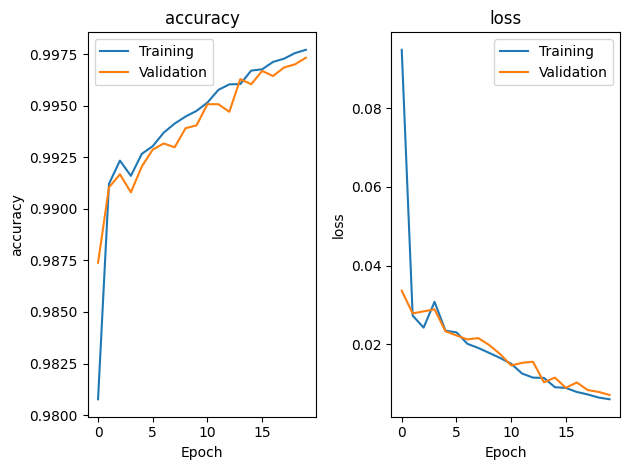

In [37]:
plot_metrics(results, ['accuracy', 'loss'])

In [42]:
model.load_weights('model-brain-mri-segmentation.weights.h5')

test_results = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)

print("Accuracy: ", test_results[1])
print("Loss: ", test_results[0])

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9970 - loss: 0.0083
Accuracy:  0.9971636533737183
Loss:  0.007891490124166012


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step


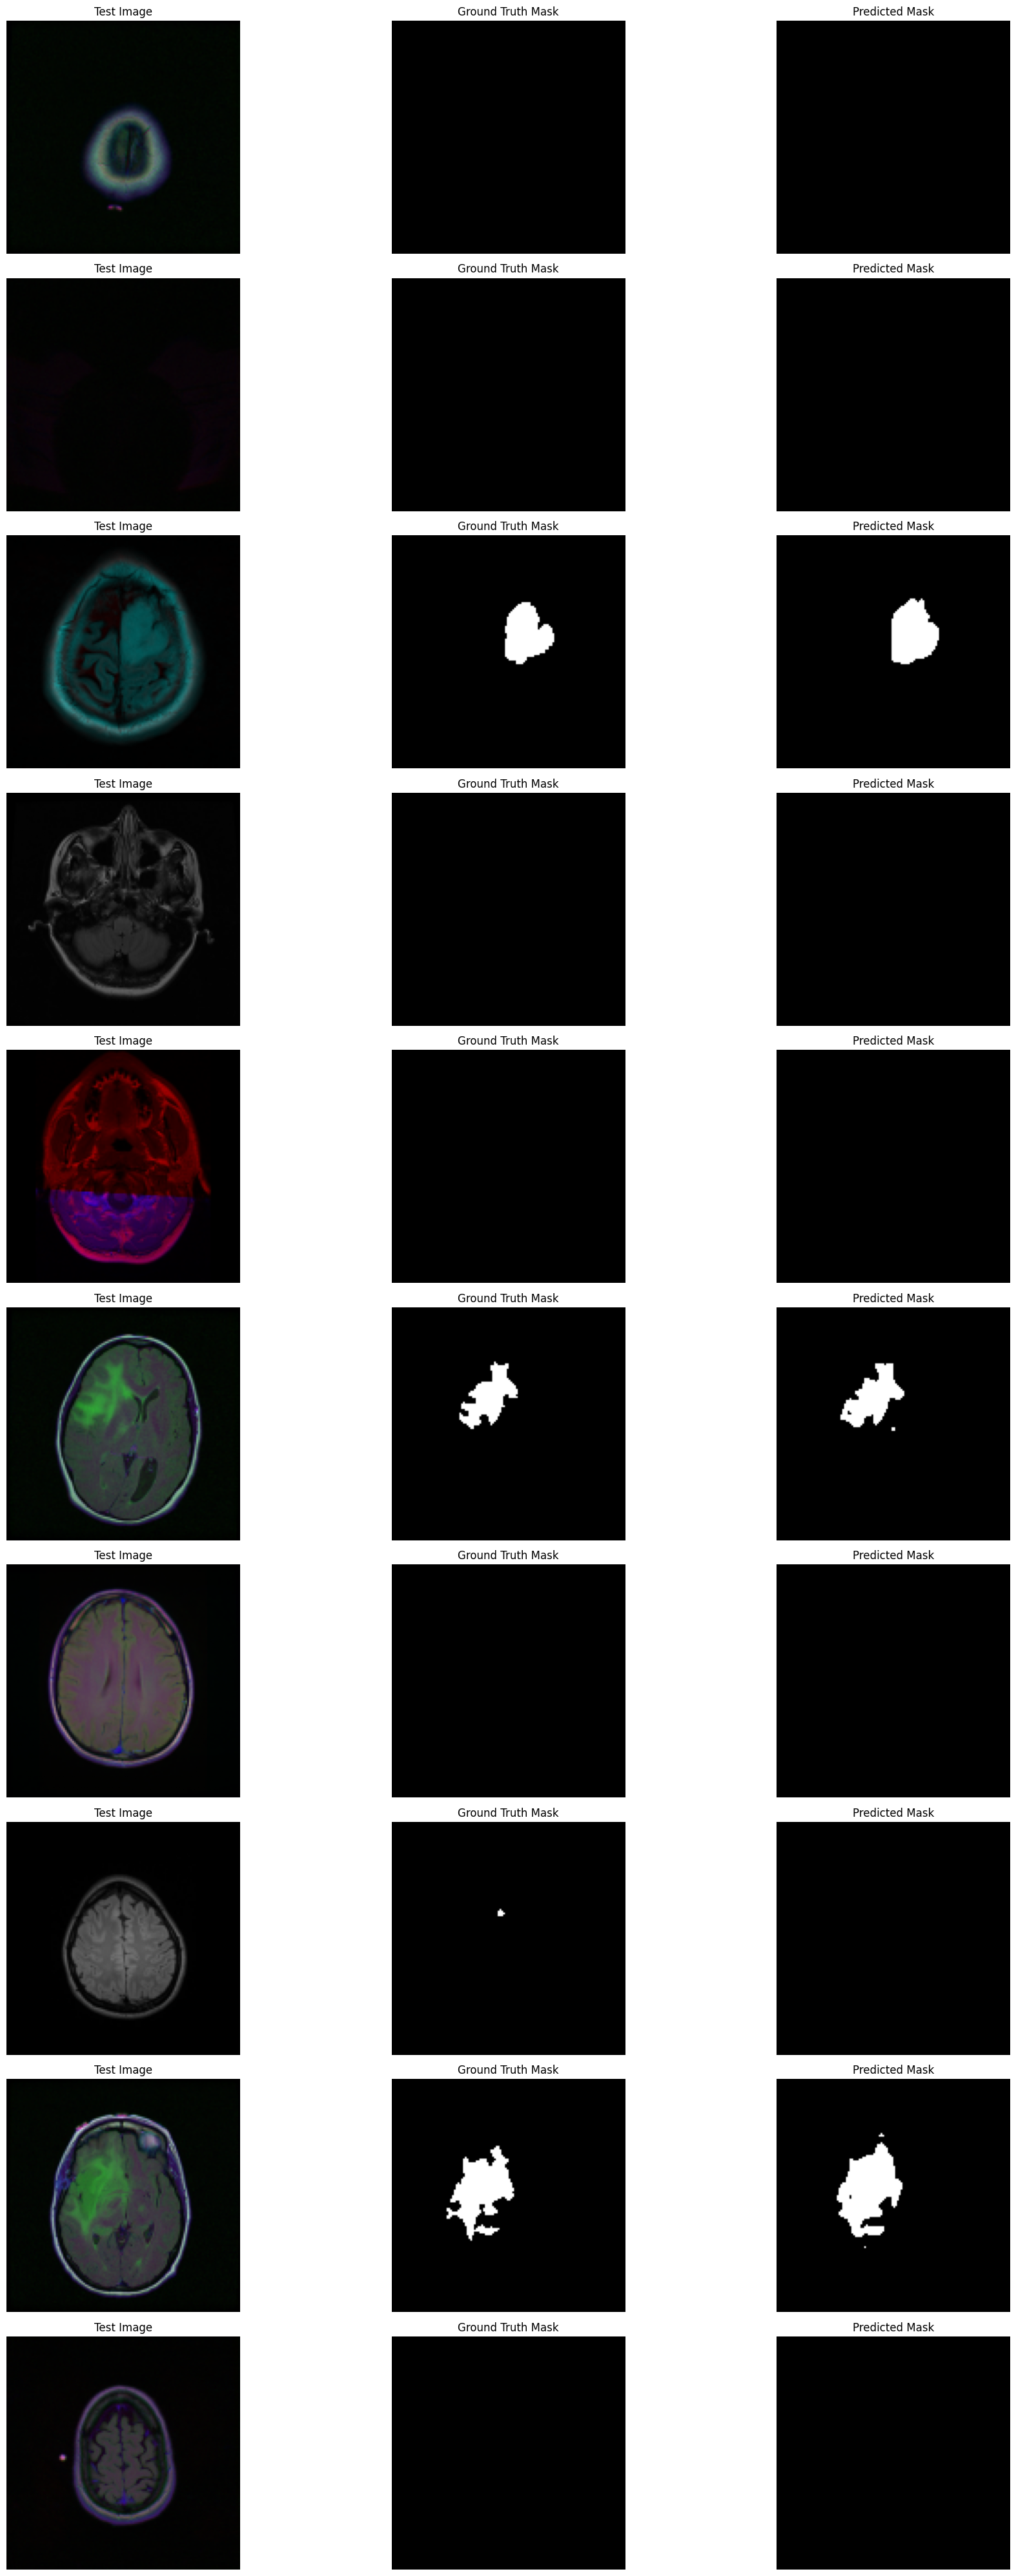

In [71]:
Y_pred = model.predict(X_test)
Y_pred_thresholded = Y_pred > 0.5

num_images_to_display = 10
indices = random.sample(range(X_test.shape[0]), num_images_to_display)

plt.figure(figsize=(20, num_images_to_display * 4))

for i, idx in enumerate(indices):
    img = X_test[idx]
    mask_true = Y_test[idx].squeeze()
    mask_pred = Y_pred_thresholded[idx].squeeze()

    plt.subplot(num_images_to_display, 3, 3 * i + 1)
    plt.imshow(img)
    plt.title('Test Image')
    plt.axis('off')

    plt.subplot(num_images_to_display, 3, 3 * i + 2)
    plt.imshow(mask_true, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(num_images_to_display, 3, 3 * i + 3)
    plt.imshow(mask_pred, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Attention U-Net

In [45]:
def attention_gate(x, g, filters):
    g = UpSampling2D(size=(2, 2))(g)
    theta_x = Conv2D(filters, (1, 1), padding='same')(x)
    phi_g = Conv2D(filters, (1, 1), padding='same')(g)
    f = Activation('relu')(Add()([theta_x, phi_g]))
    psi_f = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(f)
    return Multiply()([x, psi_f])

def unet_attention(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    c1, p1 = downsample(inputs, 64)
    c2, p2 = downsample(p1, 128)
    c3, p3 = downsample(p2, 256)
    c4, p4 = downsample(p3, 512)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    c6 = upsample(c5, attention_gate(c4, c5, 512), 512)
    c7 = upsample(c6, attention_gate(c3, c6, 256), 256)
    c8 = upsample(c7, attention_gate(c2, c7, 128), 128)
    c9 = upsample(c8, attention_gate(c1, c8, 64), 64)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model_att = unet_attention()
model_att.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_att.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_50[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 64, 64, 64)     │              0 │ conv2d_51[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_53 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_52[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 32, 32, 128)    │              0 │ conv2d_53[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_54 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_54[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 16, 16, 256)    │              0 │ conv2d_55[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_56[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 8, 8, 512)      │              0 │ conv2d_57[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_58[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_8           │ (None, 16, 16, 1024)   │              0 │ conv2d_59[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)   

 Total params: 32,426,309 (123.70 MB)

 Trainable params: 32,426,309 (123.70 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
callbacks_att = [
    EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6, verbose=1),
    ModelCheckpoint('model-brain-mri-segmentation-attention.weights.h5', save_best_only=True, save_weights_only=True, verbose=1)
]

In [47]:
results_att = model_att.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_att
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_81']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.9888 - loss: 0.9508
Epoch 1: val_loss improved from inf to 0.03355, saving model to model-brain-mri-segmentation-attention.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 99s 793ms/step - accuracy: 0.9888 - loss: 0.9443 - val_accuracy: 0.9874 - val_loss: 0.0335 - learning_rate: 0.0010
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.9902 - loss: 0.0290
Epoch 2: val_loss improved from 0.03355 to 0.02828, saving model to model-brain-mri-segmentation-attention.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 117s 661ms/step - accuracy: 0.9902 - loss: 0.0290 - val_accuracy: 0.9905 - val_loss: 0.0283 - learning_rate: 0.0010
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.9916 - loss: 0.0265
Epoch 3: val_loss did not improve from 0.02828
99/99 ━━━━━━━━━━━━━━━━━━━━ 49s 498ms/step - accuracy: 0.9916 - loss: 0.0265 - val_accuracy: 0.9904 - val_loss: 0.0318 - learning_rate: 0.0010
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/

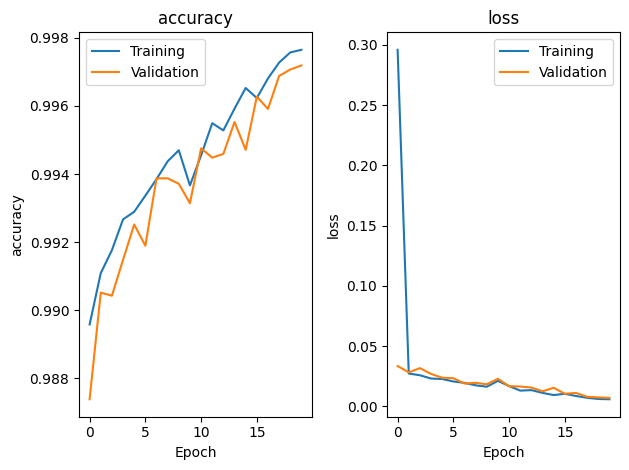

In [48]:
plot_metrics(results_att, ['accuracy', 'loss'])

In [49]:
model_att.load_weights('model-brain-mri-segmentation-attention.weights.h5')

test_results_att = model_att.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)

print("Accuracy: ", test_results_att[1])
print("Loss: ", test_results_att[0])

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.9970 - loss: 0.0081
Accuracy:  0.9971790313720703
Loss:  0.007646242622286081


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step


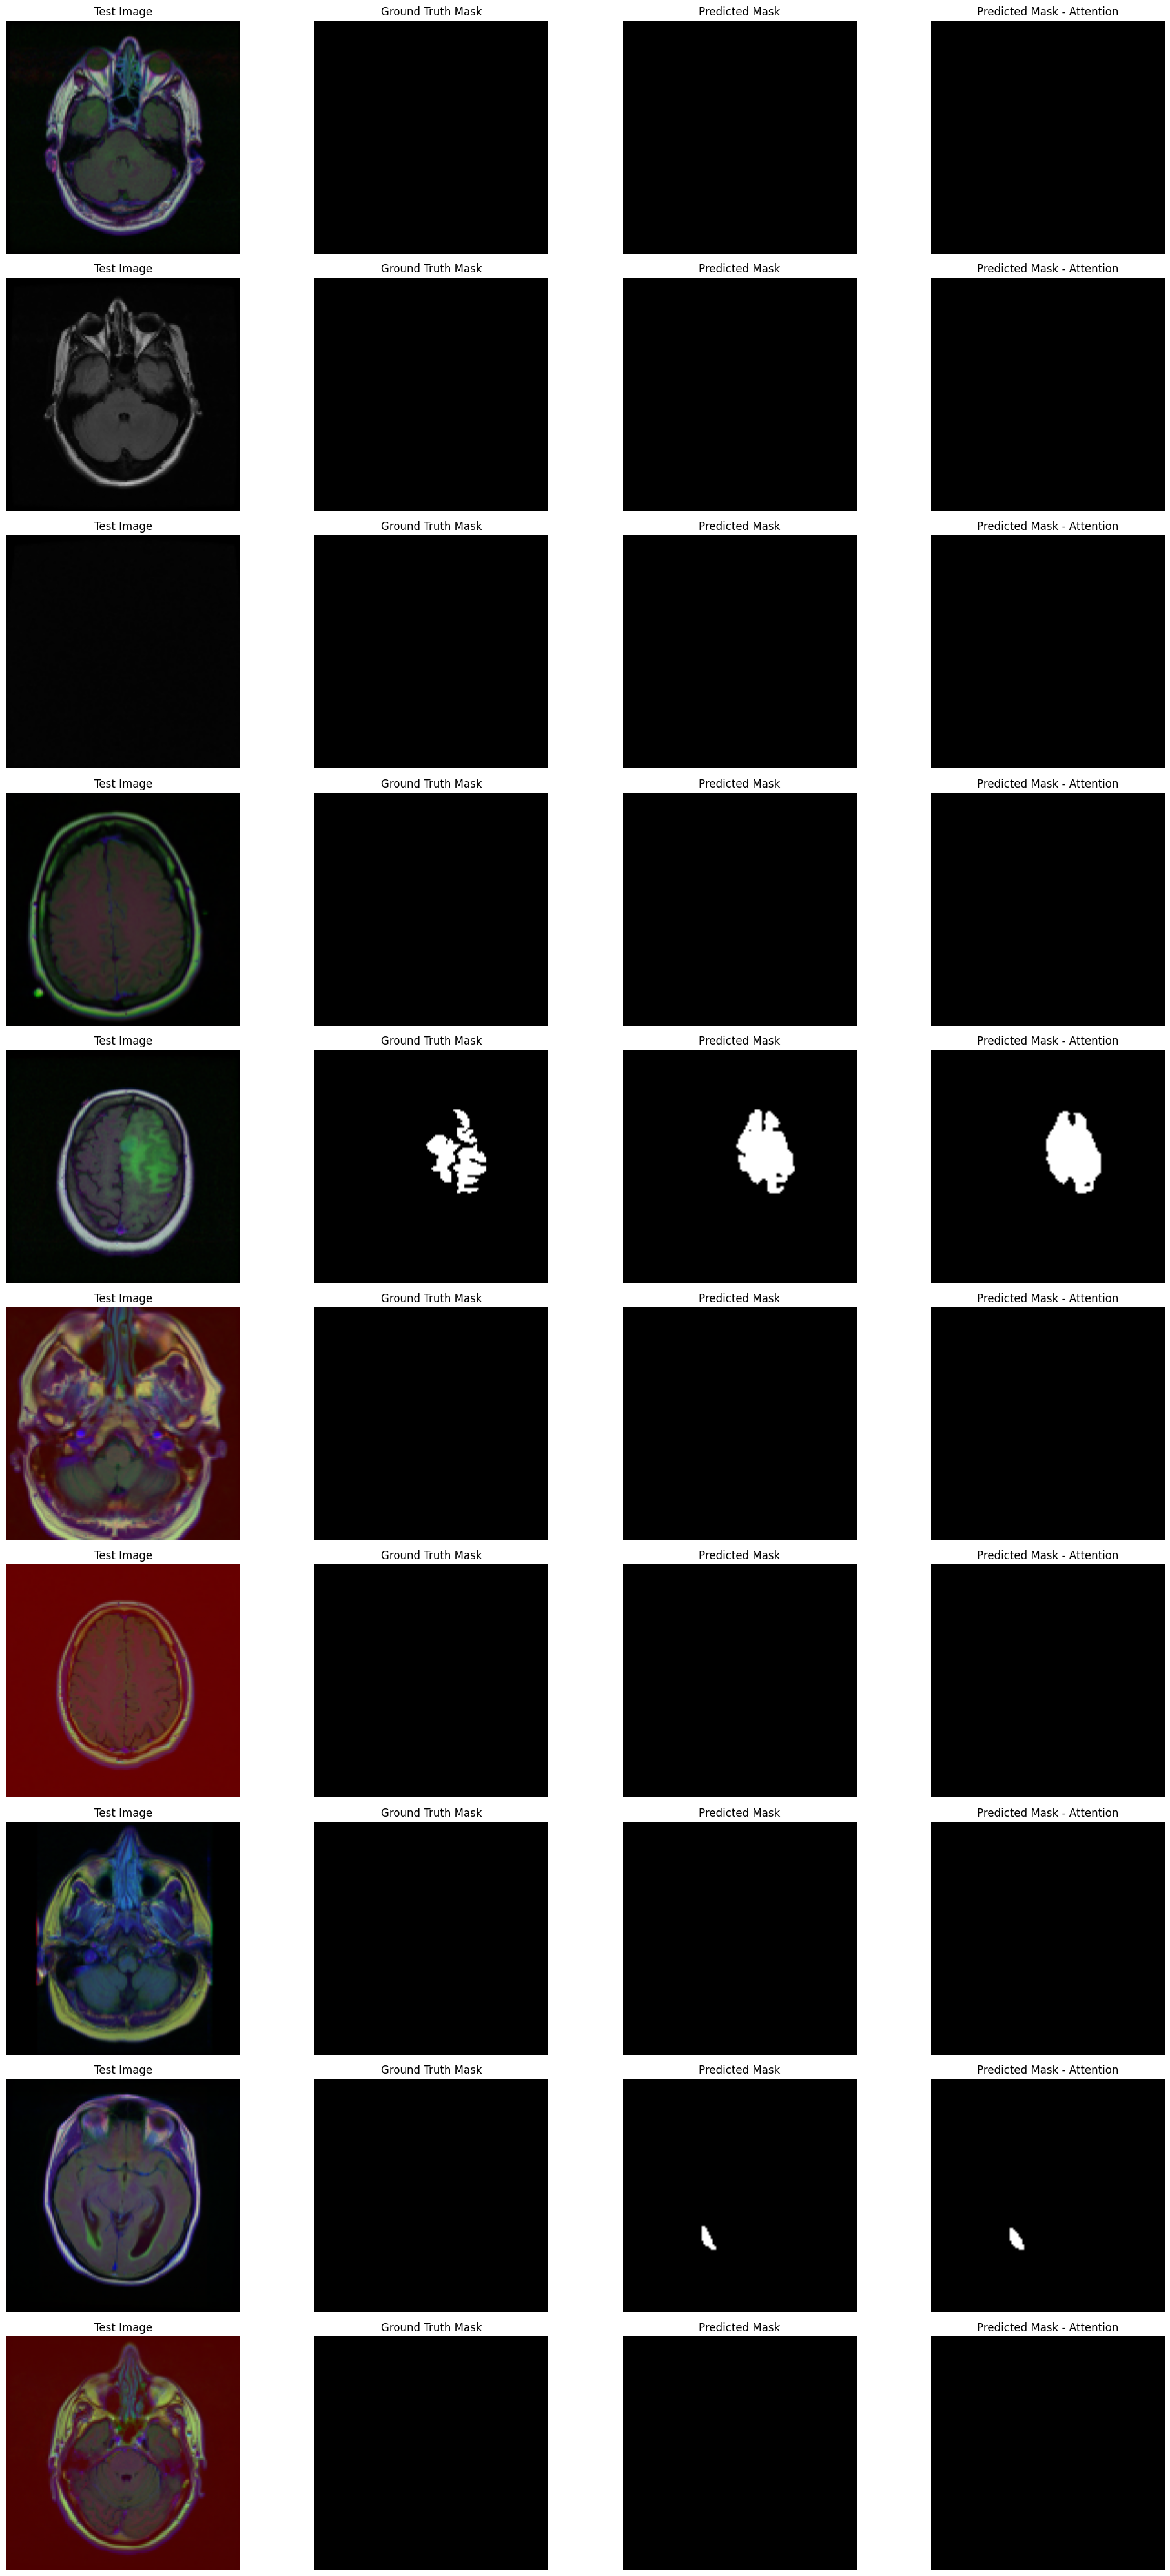

In [69]:
Y_pred_att = model_att.predict(X_test)
Y_pred_thresholded_att = Y_pred_att > 0.5

num_images_to_display = 10
indices = random.sample(range(X_test.shape[0]), num_images_to_display)

plt.figure(figsize=(20, num_images_to_display * 4))

for i, idx in enumerate(indices):
    img = X_test[idx]
    mask_true = Y_test[idx].squeeze()
    mask_pred = Y_pred_thresholded[idx].squeeze()
    mask_pred_att = Y_pred_thresholded_att[idx].squeeze()

    plt.subplot(num_images_to_display, 4, 4 * i + 1)
    plt.imshow(img)
    plt.title('Test Image')
    plt.axis('off')

    plt.subplot(num_images_to_display, 4, 4 * i + 2)
    plt.imshow(mask_true, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(num_images_to_display, 4, 4 * i + 3)
    plt.imshow(mask_pred, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(num_images_to_display, 4, 4 * i + 4)
    plt.imshow(mask_pred_att, cmap='gray')
    plt.title('Predicted Mask - Attention')
    plt.axis('off')

plt.tight_layout()
plt.show()